Simulated BGS galaxy spectra are generated using dark and bright sky spectrum then 
run through the `redrock` pipeline in order to measure redshifts. 



In [1]:
import os
import numpy as np 
# -- astropy --
from astropy.io import fits
from desispec.io import read_spectra
from desispec.io import write_spectra
from desispec.spectra import Spectra
# -- local --
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Read in Gama-Legacy catalog

In [3]:
cata = Cat.GamaLegacy()
gleg = cata.Read()

properties of the GAMA-Legacy survey 

In [4]:
redshift = gleg['gama-spec']['z_helio']
ngal = len(redshift)
print('%i galaxies in the GAMA-Legacy survey' % ngal)

39832 galaxies in the GAMA-Legacy survey


In [5]:
# apparent magnitudes from Legacy photometry
g_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
r_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
# apparent magnitude from Legacy photometry aperture flux
g_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_g'][:,1])
r_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1])
# apparent magnitude from GAMA photometry
g_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_g'])
r_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_r'])
# H-alpha line flux from GAMA spectroscopy
gama_ha = gleg['gama-spec']['ha']

# absolute magnitude calculated using GAMA photometry
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3)
g_absmag_gama = absmag_ugriz[1,:]
r_absmag_gama = absmag_ugriz[2,:]

/Users/chang/anaconda2/lib/python2.7/site-packages/feasibgs-0.0.0-py2.7.egg/feasibgs/catalogs.py:199: RuntimeWarning: divide by zero encountered in log10
/Users/chang/anaconda2/lib/python2.7/site-packages/feasibgs-0.0.0-py2.7.egg/feasibgs/catalogs.py:199: RuntimeWarning: invalid value encountered in log10


/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  
/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in subtract
  


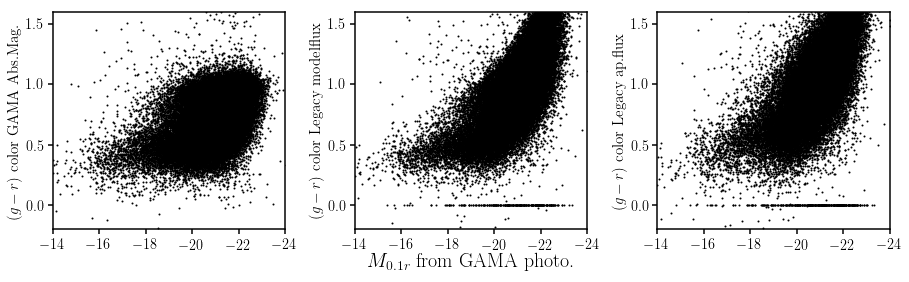

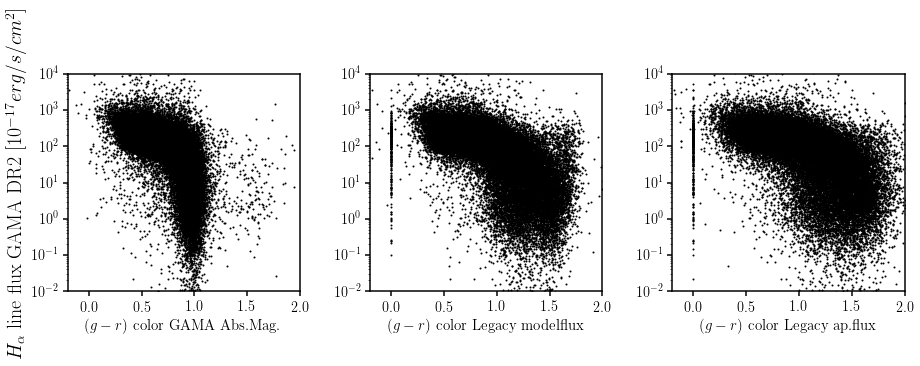

In [6]:
fig = plt.figure(figsize=(15, 4))
ys = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
ylbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, y, ylbl in zip(range(1,4), ys, ylbls):
    sub = fig.add_subplot(1,3,i)
    sub.scatter(r_absmag_gama, y, c='k', s=1.)
    if i == 2: sub.set_xlabel('$M_{0.1r}$ from GAMA photo.', fontsize=20)
    sub.set_xlim([-14., -24])
    sub.set_ylabel(r'$(g-r)$ color '+ylbl, fontsize=15)
    sub.set_ylim([-0.2, 1.6])
fig.subplots_adjust(wspace=0.3)

fig = plt.figure(figsize=(15, 4))
xs = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
xlbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, x, xlbl in zip(range(1,len(xs)+1), ys, ylbls):
    sub = fig.add_subplot(1, len(xs), i)
    sub.scatter(x, gama_ha, s=1, c='k')
    sub.set_xlabel(r'$(g-r)$ color '+xlbl, fontsize=15)
    sub.set_xlim([-0.2, 2.])
    if i == 1: sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
    sub.set_ylim([1e-2, 1e4])
    sub.set_yscale('log')
fig.subplots_adjust(wspace=0.3)

Read in the `redrock` redshift measurements for a subsample of the simulated spectra 

In [7]:
f_z_dark = ''.join([UT.dat_dir(), 'spectra/', 'gama_legacy.expSpectra.darksky.seed1.faintEmLine.zbest.fits'])
zdark_data = fits.open(f_z_dark)[1].data

f_i_dark = ''.join([UT.dat_dir(), 'spectra/', 'gama_legacy.expSpectra.darksky.seed1.faintEmLine.index'])
i_dark = np.loadtxt(f_i_dark, unpack=True, usecols=[0], dtype='i')

f_z_bright = ''.join([UT.dat_dir(), 'spectra/', 'gama_legacy.expSpectra.brightsky.seed1.faintEmLine.zbest.fits'])
zbright_data = fits.open(f_z_bright)[1].data

f_i_bright = ''.join([UT.dat_dir(), 'spectra/', 'gama_legacy.expSpectra.brightsky.seed1.faintEmLine.index']) 
i_bright = np.loadtxt(f_i_bright, unpack=True, usecols=[0], dtype='i')
assert np.array_equal(i_dark, i_bright)
print('%i redshifts' % len(zdark_data['Z']))

1000 redshifts


In [8]:
print('%i spectra w/ dark sky ZWARN != 0' % np.sum(zdark_data['ZWARN'] != 0)) 
print('%i spectra w/ bright sky ZWARN != 0' % np.sum(zbright_data['ZWARN'] != 0)) 

5 spectra w/ dark sky ZWARN != 0
7 spectra w/ bright sky ZWARN != 0


In [9]:
z_gama = redshift[i_dark]

/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  
/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in subtract
  app.launch_new_instance()


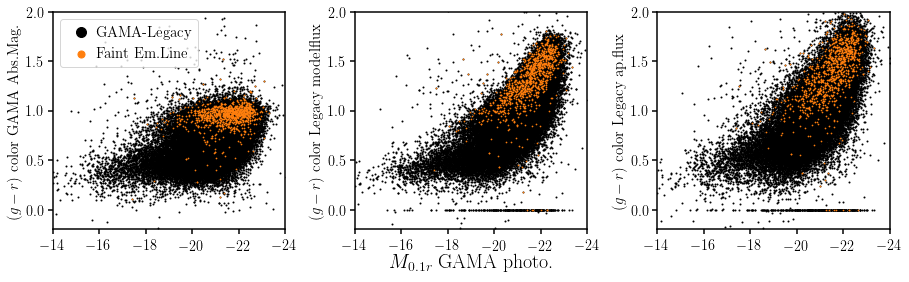

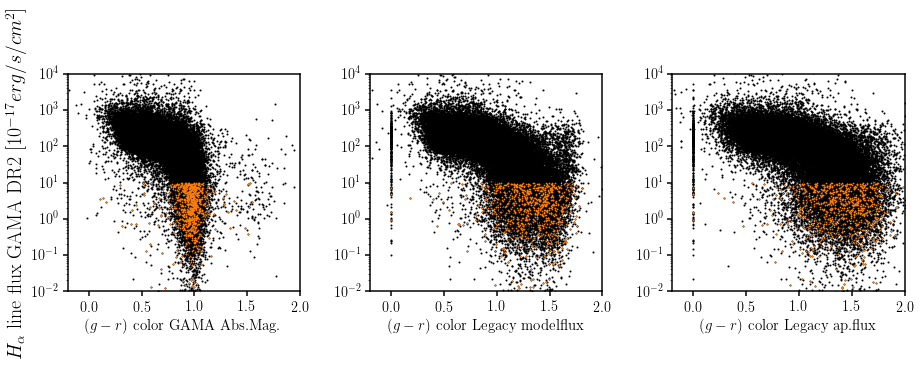

In [10]:
fig = plt.figure(figsize=(15, 4))
ys = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
ylbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, y, ylbl in zip(range(1,4), ys, ylbls):
    sub = fig.add_subplot(1,3,i)
    sub.scatter(r_absmag_gama, y, c='k', s=1., label='GAMA-Legacy')
    sub.scatter(r_absmag_gama[i_dark], y[i_dark], c='C1', s=0.5, label='Faint Em.Line')
    if i == 2: sub.set_xlabel('$M_{0.1r}$ GAMA photo.', fontsize=20)
    sub.set_xlim([-14., -24])
    sub.set_ylabel(r'$(g-r)$ color '+ylbl, fontsize=15)
    sub.set_ylim([-0.2, 2.])
    if i == 1: sub.legend(loc="upper left", markerscale=10, handletextpad=0., frameon=True, prop={'size':15})
fig.subplots_adjust(wspace=0.3)

fig = plt.figure(figsize=(15, 4))
xs = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
xlbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, x, xlbl in zip(range(1,len(xs)+1), ys, ylbls):
    sub = fig.add_subplot(1, len(xs), i)
    sub.scatter(x, gama_ha, s=1, c='k')
    sub.scatter(x[i_dark], gama_ha[i_dark], c='C1', s=0.5)
    sub.set_xlabel(r'$(g-r)$ color '+xlbl, fontsize=15)
    sub.set_xlim([-0.2, 2.])
    if i == 1: sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
    sub.set_ylim([1e-2, 1e4])
    sub.set_yscale('log')
fig.subplots_adjust(wspace=0.3)

(4.0, -2.0)

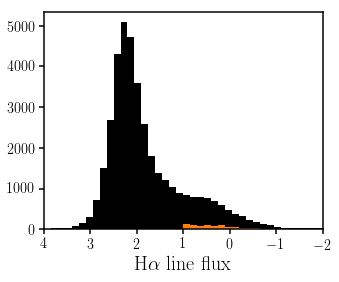

In [25]:
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(111)
_ = sub.hist(np.log10(gama_ha), histtype='stepfilled', range=(-2, 4), bins=40, color='k')
_ = sub.hist(np.log10(gama_ha[i_dark]), histtype='stepfilled', range=(-2, 4), bins=40, color='C1')
sub.set_xlabel(r'H$\alpha$ line flux', fontsize=20)
sub.set_xlim([4., -2.])

(18, 22.0)

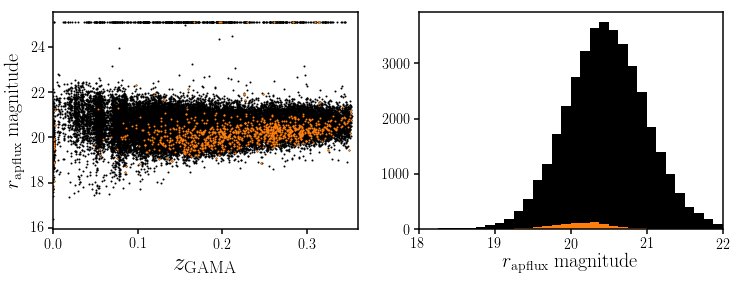

In [11]:
fig = plt.figure(figsize=(12,4))
sub1 = fig.add_subplot(121)
sub1.scatter(redshift, r_mag_legacy_apflux, s=1, c='k')
sub1.scatter(z_gama, r_mag_legacy_apflux[i_dark], s=1, c='C1')
sub1.set_xlabel(r'$z_\mathrm{GAMA}$', fontsize=25)
sub1.set_xlim([0., 0.36])
sub1.set_ylabel(r'$r_\mathrm{apflux}$ magnitude', fontsize=20)
sub2 = fig.add_subplot(122)
_ = sub2.hist(r_mag_legacy_apflux, histtype='stepfilled', range=(17, 22), bins=40, color='k')
_ = sub2.hist(r_mag_legacy_apflux[i_dark], histtype='stepfilled', range=(17, 22), bins=40, color='C1')
sub2.set_xlabel(r'$r_\mathrm{apflux}$ magnitude', fontsize=20)
sub2.set_xlim([18, 22.])

A number of galaxies have no fiber flux, so lets impose a magnitude cut

In [12]:
mag_cut = (r_mag_legacy_apflux[i_dark] < 25.0)
print('%f remain after mag cut' % (float(np.sum(mag_cut))/float(len(i_dark))))
print('%i galaxies remaining' % np.sum(mag_cut))

0.989000 remain after mag cut
989 galaxies remaining


Lets compare the redshift we measure from redrock to the "true" input redshift from GAMA. 

(0.3, 1.0)

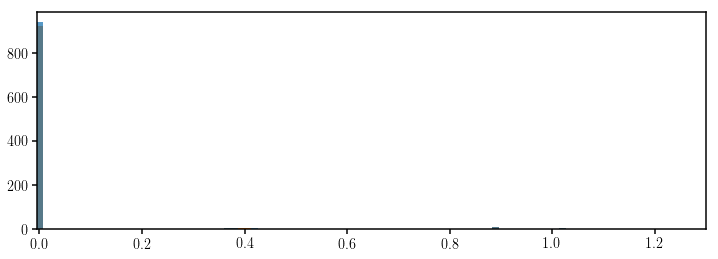

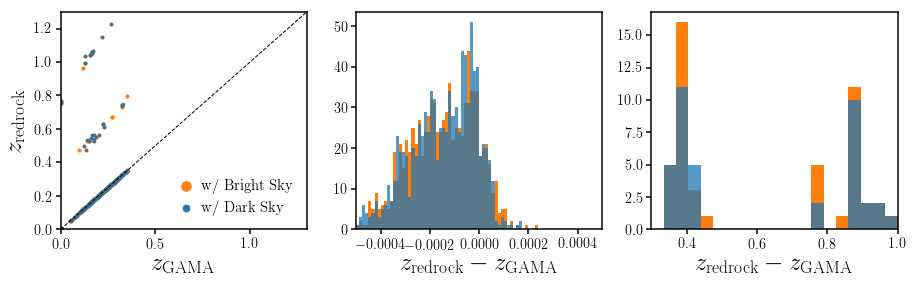

In [13]:
fig = plt.figure(figsize=(12,4))
sub = fig.add_subplot(111)
_ = sub.hist(zbright_data['Z'][mag_cut] - z_gama[mag_cut], color='C1', 
             range=(-0.005, 1.3), bins=100, histtype='stepfilled', label='w/ Bright Sky')
_ = sub.hist(zdark_data['Z'][mag_cut] - z_gama[mag_cut], color='C0', 
             range=(-0.005, 1.3), bins=100, histtype='stepfilled', alpha=0.75, label='w/ Dark Sky')
sub.set_xlim([-0.005, 1.3])


fig = plt.figure(figsize=(15,4))
sub = fig.add_subplot(131)
sub.scatter(z_gama[mag_cut], zbright_data['Z'][mag_cut], c='C1', s=10, label='w/ Bright Sky')
sub.scatter(z_gama[mag_cut], zdark_data['Z'][mag_cut], c='C0', s=5, label='w/ Dark Sky')
sub.plot([0., 10.], [0., 10.], c='k', lw=1, ls='--')
sub.set_xlabel(r"$z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([0., 1.3])
sub.set_ylabel(r"$z_\mathrm{redrock}$", fontsize=25)
sub.set_ylim([0., 1.3])
sub.legend(loc='lower right', markerscale=3, handletextpad=0., prop={'size':15})
sub = fig.add_subplot(132)
_ = sub.hist(zbright_data['Z'][mag_cut] - z_gama[mag_cut], color='C1', 
             range=(-0.00075, 0.0005), bins=100, histtype='stepfilled', label='w/ Bright Sky')
_ = sub.hist(zdark_data['Z'][mag_cut] - z_gama[mag_cut], color='C0', 
             range=(-0.00075, 0.0005), bins=100, histtype='stepfilled', alpha=0.75, label='w/ Dark Sky')
sub.set_xlabel(r"$z_\mathrm{redrock} - z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([-0.0005, 0.0005])
sub = fig.add_subplot(133)
_ = sub.hist(zbright_data['Z'][mag_cut] - z_gama[mag_cut], color='C1', 
             range=(0.3,1.), bins=20, histtype='stepfilled', label='w/ Bright Sky')
_ = sub.hist(zdark_data['Z'][mag_cut] - z_gama[mag_cut], color='C0', 
             range=(0.3, 1), bins=20, histtype='stepfilled', alpha=0.75, label='w/ Dark Sky')
sub.set_xlabel(r"$z_\mathrm{redrock} - z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([0.3, 1.0])

In [29]:
print('Dark Sky: %i galaxies have Delta z > 0.1' % np.sum(zdark_data['Z'][mag_cut] - z_gama[mag_cut] > 0.1))
print('Bright Sky: %i galaxies have Delta z > 0.1' % np.sum(zbright_data['Z'][mag_cut] - z_gama[mag_cut] > 0.1))

Dark Sky: 51 galaxies have Delta z > 0.1
Bright Sky: 65 galaxies have Delta z > 0.1


Bsed on the $\Delta z$ distribution, `redrock` recovers redshifts more successfully 
for spectra observed with bright sky... However, in these cases the `redrock` redshifts
are catastrophically wrong $\Delta z > 0.1$. Lets check, what type of galaxies these 
outliers are...

/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """
/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in subtract


Text(0.5,0.98,'galaxies with $\\Delta z > 0.1$')

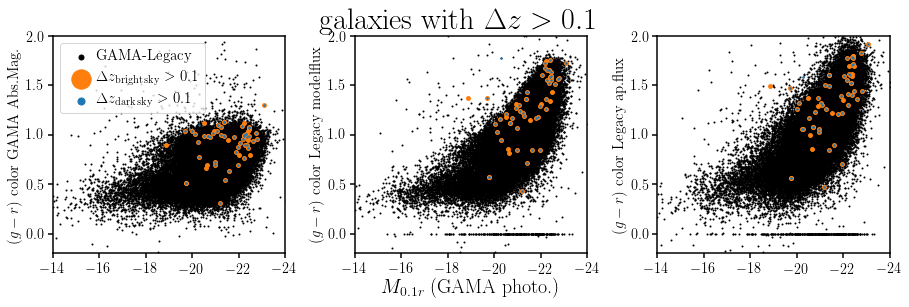

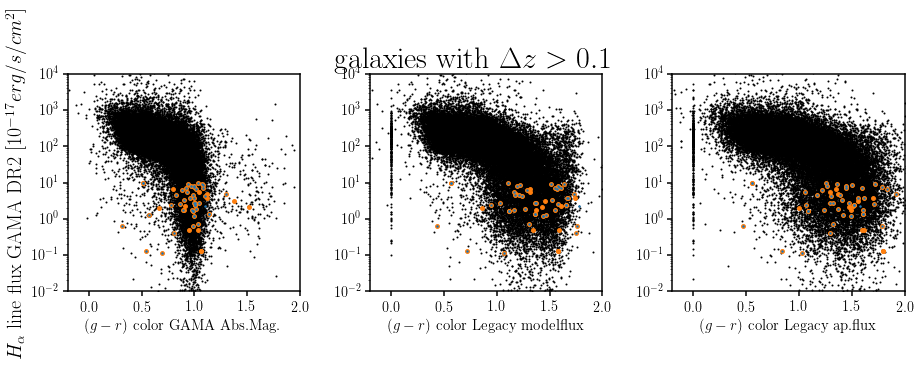

In [14]:
dark_zfail = (zdark_data['Z'][mag_cut] - z_gama[mag_cut] > 0.1) 
bright_zfail = (zbright_data['Z'][mag_cut] - z_gama[mag_cut] > 0.1)
fig = plt.figure(figsize=(15, 4))

ys = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
ylbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, y, ylbl in zip(range(1,4), ys, ylbls):
    sub = fig.add_subplot(1,3,i)
    sub.scatter(r_absmag_gama, y, c='k', s=1., label='GAMA-Legacy')
    sub.scatter(r_absmag_gama[i_dark][mag_cut][bright_zfail], y[i_dark][mag_cut][bright_zfail], c='C1', s=15, 
                label='$\Delta z_\mathrm{bright\,sky} > 0.1$')
    sub.scatter(r_absmag_gama[i_dark][mag_cut][dark_zfail], y[i_dark][mag_cut][dark_zfail], c='C0', s=2, 
                label='$\Delta z_\mathrm{dark\,sky} > 0.1$')
    if i == 2: sub.set_xlabel('$M_{0.1r}$ (GAMA photo.)', fontsize=20)
    sub.set_xlim([-14., -24])
    sub.set_ylabel(r'$(g-r)$ color '+ylbl, fontsize=15)
    sub.set_ylim([-0.2, 2.])
    if i == 1: sub.legend(loc="upper left", markerscale=5, handletextpad=0., frameon=True, prop={'size':15})
fig.subplots_adjust(wspace=0.3)
plt.suptitle('galaxies with $\Delta z > 0.1$', fontsize=30)

fig = plt.figure(figsize=(15, 4))
xs = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
xlbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, x, xlbl in zip(range(1,len(xs)+1), ys, ylbls):
    sub = fig.add_subplot(1, len(xs), i)
    sub.scatter(x, gama_ha, s=1, c='k', label='GAMA-Legacy')
    sub.scatter(x[i_dark][mag_cut][bright_zfail], gama_ha[i_dark][mag_cut][bright_zfail], c='C1', s=15, 
                label='$\Delta z_\mathrm{bright\,sky} > 0.1$')  
    sub.scatter(x[i_dark][mag_cut][dark_zfail], gama_ha[i_dark][mag_cut][dark_zfail], c='C0', s=2, 
                label='$\Delta z_\mathrm{dark\,sky} > 0.1$')  
    sub.set_xlabel(r'$(g-r)$ color '+xlbl, fontsize=15)
    sub.set_xlim([-0.2, 2.])
    if i == 1: sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
    sub.set_ylim([1e-2, 1e4])
    sub.set_yscale('log')
fig.subplots_adjust(wspace=0.3)
plt.suptitle('galaxies with $\Delta z > 0.1$', fontsize=30)

(0.0, 0.0001)

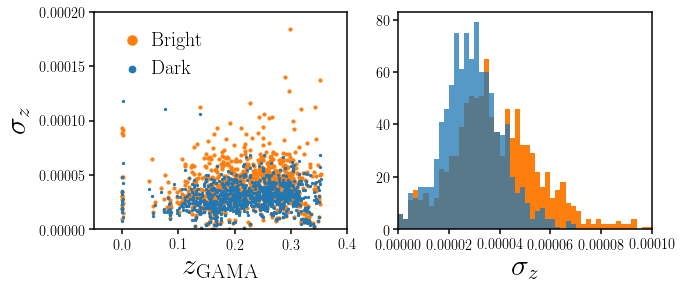

In [15]:
fig = plt.figure(figsize=(10,4))
sub = fig.add_subplot(121)
sub.scatter(z_gama[mag_cut], zbright_data['ZERR'][mag_cut], c='C1', s=10, label='Bright')
sub.scatter(z_gama[mag_cut], zdark_data['ZERR'][mag_cut], c='C0', s=5, label='Dark')
sub.set_xlabel(r"$z_\mathrm{GAMA}$", fontsize=30)
sub.set_xlim([-0.05, 0.4])
sub.set_ylabel(r"$\sigma_z$", fontsize=30)
sub.set_ylim([0, 2e-4])
sub.legend(loc='upper left', markerscale=3, handletextpad=0.0, prop={'size': 20})
sub = fig.add_subplot(122)
_ = sub.hist(zbright_data['ZERR'][mag_cut], color='C1', 
             range=(0., 0.0001), bins=50, histtype='stepfilled', label='w/ Bright Sky')
_ = sub.hist(zdark_data['ZERR'][mag_cut], color='C0', 
             range=(0., 0.0001), bins=50, histtype='stepfilled', alpha=0.75, label='w/ Dark Sky')
sub.set_xlabel(r"$\sigma_z$", fontsize=30)
sub.set_xlim([0., 0.0001])

The redshift measurement from `redrock` have larger uncertainties for the bright sky. 

Now lets see the redshift success rate (quantified as $\Delta z/(1+z) < 0.01$) as a function of various parameters. 

In [18]:
def gethist(var, ztrue, zbest, range=None, threshold=0.003):
    """ 
    """
    dz = zbest - ztrue
    dz_1pz = np.abs(dz)/(1.+ztrue)
    s1 = (dz_1pz < threshold)
    
    h0, bins = np.histogram(var, bins=100, range=range)
    hv, _ = np.histogram(var, bins=bins, weights=var)
    h1, _ = np.histogram(var[s1], bins=bins)
    
    good = h0 > 2
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    vv = hv / h0 # weighted mean of var
    
    def _eff(k, n):
        eff = k.astype("float") / (n.astype('float') + (n==0))
        efferr = np.sqrt(eff * (1 - eff)) / np.sqrt(n.astype('float') + (n == 0))
        return eff, efferr
    
    e1, ee1 = _eff(h1, h0)

    return vv, e1, ee1

Lets see how `redrock` redshift success rate, defined as $\Delta z /(1+z) < 0.003$, changes as a function of various properties

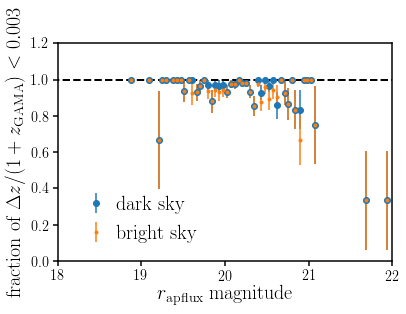

In [19]:
mm_dark, e1_dark, ee1_dark = gethist(r_mag_legacy_apflux[i_dark][mag_cut], 
                                     z_gama[mag_cut], zdark_data['Z'][mag_cut])
mm_bright, e1_bright, ee1_bright = gethist(r_mag_legacy_apflux[i_dark][mag_cut], 
                                           z_gama[mag_cut], zbright_data['Z'][mag_cut])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([17., 22.], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, fmt='.C1', label="bright sky")
sub.set_xlabel(r'$r_\mathrm{apflux}$ magnitude', fontsize=20)
sub.set_xlim([18., 22.])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower left', handletextpad=0., prop={'size': 20})

Once the outliers are removed, the spectra with dark sky has a higher redshift success rate. 

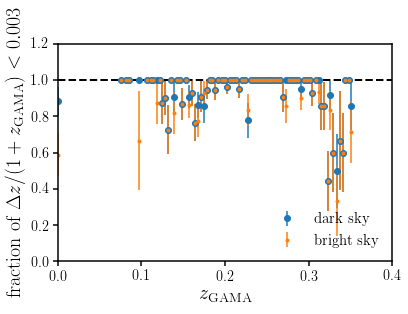

In [22]:
mm_dark, e1_dark, ee1_dark = gethist(redshift[i_dark][mag_cut], z_gama[mag_cut], zdark_data['Z'][mag_cut])
mm_bright, e1_bright, ee1_bright = gethist(redshift[i_dark][mag_cut], z_gama[mag_cut], zbright_data['Z'][mag_cut])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([0., 0.5], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, fmt='.C1', label="bright sky")
sub.set_xlabel(r'$z_\mathrm{GAMA}$', fontsize=20)
sub.set_xlim([0.0, 0.4])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', prop={'size': 15})

(0.0, 1.2)

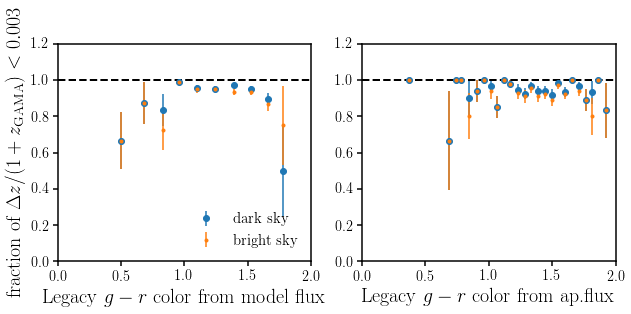

In [23]:
mm_dark, e1_dark, ee1_dark = gethist((g_mag_legacy - r_mag_legacy)[i_dark][mag_cut], 
                                     z_gama[mag_cut], zdark_data['Z'][mag_cut])
mm_bright, e1_bright, ee1_bright = gethist((g_mag_legacy - r_mag_legacy)[i_dark][mag_cut], 
                                           z_gama[mag_cut], zbright_data['Z'][mag_cut])

fig = plt.figure(figsize=(10,4))
sub = fig.add_subplot(121)
sub.plot([0., 2.], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, fmt='.C1', label="bright sky")
sub.set_xlabel(r'Legacy $g-r$ color from model flux', fontsize=20)
sub.set_xlim([0., 2.])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', prop={'size': 15})

mm_dark, e1_dark, ee1_dark = gethist((g_mag_legacy_apflux - r_mag_legacy_apflux)[i_dark][mag_cut], 
                                     z_gama[mag_cut], zdark_data['Z'][mag_cut])
mm_bright, e1_bright, ee1_bright = gethist((g_mag_legacy_apflux - r_mag_legacy_apflux)[i_dark][mag_cut], 
                                           z_gama[mag_cut], zbright_data['Z'][mag_cut])
sub = fig.add_subplot(122)
sub.plot([0., 2.], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, fmt='.C1', label="bright sky")
sub.set_xlabel(r'Legacy $g-r$ color from ap.flux', fontsize=20)
sub.set_xlim([0., 2.])
sub.set_ylim([0., 1.2])


Once the extreme `redrock` outliers are excluded, the spectra with dark sky does better...